In [2]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

下面这段代码定义了一个名为 timestep_embedding 的函数，用于生成正弦位置嵌入（sinusoidal positional embeddings），以编码时间步长信息。这种嵌入常被应用于序列建模任务，特别是在基于扩散模型的生成任务中，用来为每个时间步赋予特定的周期性特征。
- timesteps: 一个形状为 (N,) 的一维张量，包含N个浮点数索引，代表每个批次元素的时间步长。这些索引可以是整数或分数。
- dim: 输出嵌入的维度。生成的嵌入将具有形状 (N, dim)。
- max_period: 控制最小频率的参数，以此影响嵌入的周期特性。默认值为 10000。

In [3]:
# 使用正弦位置嵌入编码时间步长
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [10]:
# 假设使用 CPU 设备（如果在 GPU 上运行，请替换为相应 GPU 设备）
device = torch.device("cpu")

# 创建一个形状为 (1,) 的张量，表示单个时间步长值为 10
timesteps_tensor = torch.tensor([1, 2, 3, 4, 5], device=device)

# 调用函数，传入张量作为 timesteps 参数
timestep = timestep_embedding(timesteps_tensor, 20)
timestep

tensor([[ 5.4030e-01,  9.2180e-01,  9.8747e-01,  9.9801e-01,  9.9968e-01,
          9.9995e-01,  9.9999e-01,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          8.4147e-01,  3.8767e-01,  1.5783e-01,  6.3054e-02,  2.5116e-02,
          9.9998e-03,  3.9811e-03,  1.5849e-03,  6.3096e-04,  2.5119e-04],
        [-4.1615e-01,  6.9942e-01,  9.5018e-01,  9.9205e-01,  9.9874e-01,
          9.9980e-01,  9.9997e-01,  9.9999e-01,  1.0000e+00,  1.0000e+00,
          9.0930e-01,  7.1471e-01,  3.1170e-01,  1.2586e-01,  5.0217e-02,
          1.9999e-02,  7.9621e-03,  3.1698e-03,  1.2619e-03,  5.0238e-04],
        [-9.8999e-01,  3.6764e-01,  8.8908e-01,  9.8214e-01,  9.9716e-01,
          9.9955e-01,  9.9993e-01,  9.9999e-01,  1.0000e+00,  1.0000e+00,
          1.4112e-01,  9.2997e-01,  4.5775e-01,  1.8816e-01,  7.5285e-02,
          2.9995e-02,  1.1943e-02,  4.7547e-03,  1.8929e-03,  7.5357e-04],
        [-6.5364e-01, -2.1631e-02,  8.0569e-01,  9.6832e-01,  9.9496e-01,
          9.9920e-01,  9.9987e-01, 

下面这段代码定义了两个类，TimestepBlock 和 TimestepEmbedSequential，以及一个用于创建归一化层的辅助函数 norm_layer。下面是详细的解释：

## TimestepBlock 类
这是一个抽象基类，继承自 PyTorch 中的 nn.Module。它代表任何在前向传播过程中接受时间步长嵌入作为第二个输入参数的模块。
- TimestepBlock 类继承自 nn.Module，这是 PyTorch 中构建神经网络的基本单元。
- 类的文档字符串（docstring）指出此类适用于那些在前向传播 (forward) 函数中接收时间步长嵌入作为第二个参数的模块。
- 使用 @abstractmethod 装饰器标记 forward 方法，这意味着所有继承自 TimestepBlock 的子类必须实现这个方法。该方法接受两个参数：
  - x: 表示模型的常规输入，如图像特征、序列数据等。
  - emb: 时间步长嵌入，通常是一组与时间步长相关的向量，它们包含了关于时间步长的信息，可以被模型用来捕捉时间动态。
- 由于 forward 方法被声明为抽象方法，这里没有提供具体的实现。在实际使用时，需要继承 TimestepBlock 并在子类中实现 forward 方法，处理 x 和 emb 两个输入。

**设计意图与使用场景：**

TimestepBlock 类的主要目的是提供一个通用接口，供其他模块或模型继承，以确保它们在前向传播过程中能够接收并利用时间步长嵌入。这样的设计有几个好处：
- 一致性：通过继承 TimestepBlock，所有支持时间步长嵌入的模块都遵循相同的接口规范，即 forward 方法接受 (x, emb) 作为输入。这有助于代码的整洁性和可维护性。
- 可组合性：由于 TimestepBlock 类型的模块具有统一接口，它们可以方便地与其他模块（无论是否支持时间步长嵌入）组合在一起，形成更复杂的模型结构。比如在 TimestepEmbedSequential 类中，可以识别并正确处理 TimestepBlock 类型的子模块。
- 抽象与扩展：作为抽象基类，TimestepBlock 不直接提供实现细节，而是强制子类去实现 forward 方法。这允许开发者根据具体需求灵活设计各种支持时间步长嵌入的模块，同时确保这些模块符合统一的接口约定。
 
## TimestepEmbedSequential 类
这是一个组合类，继承自 nn.Sequential 和 TimestepBlock。它的目的是作为一个容器，能够顺序执行多个模块，并且能正确地将时间步长嵌入传递给那些支持接收该嵌入的子模块。
- TimestepEmbedSequential 类同时继承自 nn.Sequential 和 TimestepBlock。nn.Sequential 是 PyTorch 中一个有序的模块容器，它按顺序执行内部存储的模块。
- 类的文档字符串说明了这是一个顺序模块，能够将时间步长嵌入传递给支持接收该嵌入的子模块。
- forward 方法重写了 nn.Sequential 的默认实现，使其能够处理额外的时间步长嵌入参数 emb：
  - 遍历容器中的每一个模块（layer）：
   如果当前模块是 TimestepBlock 类型（即它支持接收时间步长嵌入），则调用其 forward 方法，传入 x 和 emb。
   否则，调用模块的 forward 方法，只传入 x（不传递时间步长嵌入）。
  - 返回经过所有模块处理后的结果 x。
 
## 辅助函数 norm_layer
这是一个简单的函数，用于根据给定的通道数（channels）创建一个归一化层。在这个例子中，使用的是 nn.GroupNorm。
- norm_layer 接受一个参数 channels，表示要归一化的特征图的通道数。
- 函数返回一个 nn.GroupNorm 实例，其中 num_groups 设置为 32，num_channels 设置为传入的 channels 参数。GroupNorm 将输入特征图按通道分成 32 个小组，对每个小组内的通道进行独立归一化，有助于提高模型的泛化能力和训练稳定性。

In [11]:
class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

# use GN for norm layer
def norm_layer(channels):
    return nn.GroupNorm(32, channels)

下面这段代码定义了一个名为 ResidualBlock 的类，它继承自之前介绍的 TimestepBlock 类，并实现了具体的前向传播 (forward) 方法。这个类代表一个残差块（Residual Block），它在传统残差块的基础上，加入了对时间步长嵌入的支持。以下是代码的详细解释：
- ResidualBlock 类继承自 TimestepBlock，表明这是一个支持时间步长嵌入的模块。根据 TimestepBlock 的约定，ResidualBlock 的 forward 方法需要接受两个参数：常规输入 x 和时间步长嵌入 t。
- 初始化方法接收四个参数：
  - in_channels: 输入特征图的通道数。
  - out_channels: 输出特征图的通道数。
  - time_channels: 时间步长嵌入的维度。
  - dropout: 残差块内部使用的 dropout 率。
- 使用 super().__init__() 调用父类（TimestepBlock）的初始化方法。
接下来定义了三个主要组件：两个卷积层序列（conv1 和 conv2）以及一个时间步长嵌入投影层（time_emb）。

**组件1：conv1。** conv1 是一个 nn.Sequential 模块，包含以下组件：
- norm_layer(in_channels): 使用 norm_layer 辅助函数创建的归一化层，对输入特征图进行归一化。
- nn.SiLU(): 使用 SiLU（Sigmoid Linear Unit）激活函数。
- nn.Conv2d(...): 一个 2D 卷积层，将输入特征图的通道数从 in_channels 转换为 out_channels，使用 3x3 的卷积核和 1 个像素的 padding。

**组件2：time_emb。** time_emb 是一个 nn.Sequential 模块，用于将时间步长嵌入 t 投影到与输出特征图相同维度的空间。包含以下组件：
- nn.SiLU(): 使用 SiLU 激活函数。
- nn.Linear(time_channels, out_channels): 一个线性层，将时间步长嵌入的维度从 time_channels 转换为 out_channels。

**组件3：conv2。** conv2 是另一个 nn.Sequential 模块，包含以下组件：
- norm_layer(out_channels): 使用 norm_layer 辅助函数创建的归一化层，对中间特征图进行归一化。
- nn.SiLU(): 使用 SiLU 激活函数。
- nn.Dropout(p=dropout): 一个 Dropout 层，以 dropout 率随机丢弃特征图的部分元素，防止过拟合。
- nn.Conv2d(...): 又一个 2D 卷积层，保持特征图通道数为 out_channels，使用 3x3 的卷积核和 1 个像素的 padding。

**shortcut：跳连。** 根据输入和输出特征图通道数是否相等，选择不同的快捷连接方式：
- 如果 in_channels ≠ out_channels，创建一个 1x1 卷积层 (nn.Conv2d)，将输入特征图的通道数转换为与输出特征图相同的数量。
- 如果 in_channels = out_channels，使用 nn.Identity 模块作为快捷连接，即直接将输入特征图传递至输出，不做任何变换。

**前向传播：**

前向传播方法接受两个参数：
- x: 常规输入特征图，形状为 [batch_size, in_dim, height, width]。
- t: 时间步长嵌入，形状为 [batch_size, time_dim]。
计算过程：
1. 通过 conv1 处理输入特征图 x，得到中间特征图 h。
2. 将时间步长嵌入 t 通过 time_emb 投影到与中间特征图 h 相同的维度，然后将其添加到 h 的每个空间位置上（通过 [:, :, None, None] 操作扩展维度）。这一步将时间步长信息融入到中间特征图中。
3. 通过 conv2 处理融合了时间步长信息的中间特征图 h。
4. 将 conv2 的输出与快捷连接（shortcut）的输出相加，得到最终输出特征图。

综上所述，ResidualBlock 类实现了一个支持时间步长嵌入的残差块。在前向传播过程中，它首先通过两个卷积层序列处理输入特征图，然后将时间步长嵌入投影并添加到中间特征图中，接着再经过一个卷积层序列，最后与原始输入特征图（或其适当调整后的版本）相加，形成残差连接。这样的设计允许模型在利用时间步长信息的同时，保留残差网络的优势，如深度学习的优化难题缓解和特征表示能力增强。

In [12]:
# Residual block
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()


    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)

下面这段代码定义了一个名为 AttentionBlock 的类，它继承自 PyTorch 的 nn.Module 类，实现了一个带有快捷连接（shortcut）的注意力块。该注意力块采用了类似 Transformer 中的多头自注意力机制，但适用于 2D 特征图。以下是代码的详细解释：

AttentionBlock 类继承自 nn.Module，这是 PyTorch 中构建神经网络的基本单元。
- 初始化方法接收两个参数：
  - channels: 输入特征图的通道数。
  - num_heads: 注意力头的数量，默认为 1。
- 使用 super().__init__() 调用父类（nn.Module）的初始化方法。
- 设置类属性 num_heads，并使用断言确保 channels 能被 num_heads 整除，这是多头注意力机制的一个常见要求。

创建以下组件：
- self.norm: 使用 norm_layer 辅助函数创建的归一化层，对输入特征图进行归一化。
- self.qkv: 一个 2D 卷积层（nn.Conv2d），将输入特征图的通道数扩展为 channels * 3，用以生成查询（Q）、键（K）和值（V）向量。使用 1x1 的卷积核且无偏置。
- self.proj: 另一个 2D 卷积层，保持特征图通道数为 channels，同样使用 1x1 的卷积核。

前向传播：
- 前向传播方法接受一个参数：

  x: 输入特征图，形状为 (B, C, H, W)，其中 B 为批量大小，C 为通道数，H 和 W 分别为特征图的高度和宽度。

- 计算过程：

1. 获取输入特征图的形状 (B, C, H, W)。
2. 使用 self.norm 对输入特征图进行归一化。
3. 通过 self.qkv 生成查询、键、值向量（QKV），形状为 (B, C*3, H, W)。
4. 将 QKV 向量展平并拆分为 (B*self.num_heads, C//self.num_heads, H*W) 形状的查询、键、值矩阵，分别记为 q、k、v。
5. 计算缩放因子 scale，用于对查询和键向量进行缩放，有助于稳定注意力计算。
6. 使用 torch.einsum 计算注意力分数，通过矩阵乘法和求和操作实现 query * key^T，得到形状为 (B*self.num_heads, H*W, H*W) 的注意力矩阵。
7. 对注意力矩阵应用 softmax 函数，使其元素之和为 1，得到归一化的注意力权重。
8. 再次使用 torch.einsum 计算注意力加权和，将注意力权重与值矩阵相乘，得到形状为 (B*self.num_heads, C//self.num_heads, H*W) 的输出特征。
9. 将输出特征重塑回 (B, C, H, W) 形状。
10. 通过 self.proj 将输出特征映射回原始通道数 C。
11. 最后，将经过注意力机制处理后的特征图 h 与原始输入特征图 x 相加，形成快捷连接，返回最终输出特征图。

综上，AttentionBlock 类实现了一个带有快捷连接的注意力模块，适用于处理 2D 特征图。它通过多头自注意力机制，让特征图的不同位置之间能够相互关注，增强了模型的全局信息捕获能力。在前向传播过程中，首先通过卷积层生成查询、键、值向量，计算注意力权重，然后进行注意力加权求和，最后通过投影层还原通道数，并与原始输入特征图相加，形成残差连接。这样的设计允许模型在利用注意力机制捕获长程依赖的同时，保留原始特征图的信息，并缓解深度学习的优化难题。

In [13]:
# Attention block with shortcut
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0
        
        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x

下面这段代码定义了两个 PyTorch 模块：Upsample 和 Downsample，分别用于对输入特征图进行上采样和下采样操作。以下是每个类的详细解释：
## Upsample类
Upsample 类继承自 nn.Module。

**初始化方法 (__init__)：**

- 接收两个参数：
  - channels: 输入特征图的通道数。
  - use_conv: 布尔值，指示是否在上采样后附加一个 3x3 卷积层。
- 设置类属性 use_conv。
- 如果 use_conv=True，则创建一个 nn.Conv2d 层，其具有以下配置：
  - 输入和输出通道数均为 channels。
  - 卷积核大小为 3x3。
  - 使用 1 像素的填充（padding=1），使得卷积后特征图尺寸不变。
**前向传播方法 (forward)：**
- 接收一个参数：
  - x: 输入特征图。
- 使用 F.interpolate 对输入特征图进行上采样，设置 scale_factor=2 表示放大两倍，mode="nearest" 表示采用最近邻插值方法。
- 如果 self.use_conv=True，则将上采样后的特征图传递给之前创建的 3x3 卷积层进行处理。
- 返回经过上采样（可能包含卷积）后的特征图。

## Downsample 类
Downsample 类同样继承自 nn.Module。

**初始化方法 (__init__)：**
- 接收两个参数：
  - channels: 输入特征图的通道数。
  - use_conv: 布尔值，指示是否使用 3x3 卷积层进行下采样，否则使用平均池化层。
- 设置类属性 use_conv。
- 根据 use_conv 的值创建不同的下采样操作：
  
  若 use_conv=True，创建一个 nn.Conv2d 层，其配置如下：
  - 输入和输出通道数均为 channels。
  - 卷积核大小为 3x3。
  - 设置步幅（stride=2）为 2，以实现下采样。
  - 使用 1 像素的填充（padding=1），保持输出特征图的尺寸与使用相同步幅的池化层时一致。
  
  若 use_conv=False，创建一个 nn.AvgPool2d 层，仅设置步幅为 2，即进行 2x2 平均池化以实现下采样。

**前向传播方法 (forward)：**

- 接收一个参数：
  - x: 输入特征图。
- 直接将输入特征图传递给之前根据 use_conv 创建的下采样操作层（卷积层或平均池化层）。
- 返回经过下采样后的特征图。

这两个类提供了灵活的上采样和下采样模块，可以根据需求选择是否在采样操作后附加一个 3x3 卷积层。对于上采样，使用 F.interpolate 进行最近邻插值放大特征图尺寸，如果指定 use_conv=True，则在其后添加一个保持通道数不变的 3x3 卷积层。对于下采样，可以选择使用具有步幅为 2 的 3x3 卷积层或 2x2 平均池化层。这些模块可以方便地嵌入到深度学习模型中，调整特征图的空间分辨率。

In [14]:
# upsample
class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

# downsample
class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)

下面这段代码定义了一个名为 `UNetModel` 的类，它继承自 PyTorch 的 `nn.Module` 类，实现了一个结合注意力机制（Attention）和时间步嵌入（Time Embedding）的 U-Net 架构模型。以下是代码的详细解释：

**类定义与初始化方法 (`__init__`)：**
- `UNetModel` 类继承自 `nn.Module`，用于构建 U-Net 结构的深度学习模型。

- 初始化方法接收多个参数，用于配置模型结构：
  - `in_channels`: 输入特征图的通道数。
  - `model_channels`: 基础通道数，用于确定网络各层的初始通道数。
  - `out_channels`: 输出特征图的通道数。
  - `num_res_blocks`: 每个分辨率级别包含的残差块（ResidualBlock）数量。
  - `attention_resolutions`: 列表，指定在哪几个分辨率级别应用注意力模块（AttentionBlock）。
  - `dropout`: 全局 dropout 率。
  - `channel_mult`: 列表，表示各分辨率级别的通道数倍增系数。
  - `conv_resample`: 布尔值，决定是否使用卷积进行下采样和上采样。
  - `num_heads`: 注意力模块中头部的数量。

- 初始化方法内部，根据上述参数设置类属性，并创建以下组件：

  - **时间步嵌入 (`time_embed`)**：
    - 使用 `nn.Sequential` 构建一个包含两层全连接层（`nn.Linear`）和一层 SiLU 激活函数（`nn.SiLU`）的时间步嵌入模块。该模块将时间步长嵌入转换为与模型基础通道数（`model_channels`）四倍大小的向量。

  - **下采样块 (`down_blocks`)**：
    - 使用 `nn.ModuleList` 存储多个 `TimestepEmbedSequential` 模块，每个模块包含一个或多个 `ResidualBlock`、`AttentionBlock` 和 `Downsample` 模块。这些模块按照分辨率级别和残差块数量依次排列，构建 U-Net 的下采样路径。下采样的通道数按 `channel_mult` 参数逐渐增加，同时根据 `attention_resolutions` 在指定分辨率级别添加注意力模块。下采样操作通过 `Downsample` 类实现，可以选择使用卷积或平均池化进行下采样。

  - **中间块 (`middle_block`)**：
    - 包含一个 `TimestepEmbedSequential` 模块，内部包含三个子模块：两个 `ResidualBlock` 之间夹一个 `AttentionBlock`。中间块使用最高的通道数。

  - **上采样块 (`up_blocks`)**：
    - 使用 `nn.ModuleList` 存储多个 `TimestepEmbedSequential` 模块，每个模块包含一个或多个 `ResidualBlock`、`AttentionBlock` 和 `Upsample` 模块。这些模块按照分辨率级别和残差块数量依次排列，构建 U-Net 的上采样路径。上采样的通道数按 `channel_mult` 参数逐渐减少，同时根据 `attention_resolutions` 在指定分辨率级别添加注意力模块。上采样操作通过 `Upsample` 类实现，可以选择使用卷积或最近邻插值进行上采样。

  - **输出模块 (`out`)**：
    - 包含一个 `nn.Sequential` 模块，内部包含归一化层（`norm_layer`）、SiLU 激活函数和一个 3x3 卷积层（`nn.Conv2d`），将上采样后的特征图转换为所需输出通道数。

**前向传播方法 (`forward`)：**

- 前向传播方法接收两个参数：
  - `x`: 输入特征图，形状为 `(N, C_in, H, W)`，其中 `N` 为批量大小，`C_in` 为输入通道数，`H` 和 `W` 分别为特征图的高度和宽度。
  - `timesteps`: 一个包含时间步长的 1D 张量，形状为 `(N,)`。

- 计算过程：
  1. 通过 `timestep_embedding` 函数计算时间步长嵌入，并通过 `time_embed` 模块对其进行转换。
  2. 遍历下采样块 (`down_blocks`)，将输入特征图 `x` 逐步下采样，并存储每个分辨率级别的特征图到列表 `hs`。
  3. 应用中间块 (`middle_block`) 对下采样后得到的特征图进行处理。
  4. 从下采样特征图列表 `hs` 开始，遍历上采样块 (`up_blocks`)，将上采样特征图与对应的下采样特征图拼接后，通过上采样块进行处理。每次处理后，将拼接得到的新特征图作为下一次上采样的输入。
  5. 将经过上采样块处理后的最终特征图传递给输出模块 (`out`)，得到模型输出。

综上，`UNetModel` 类实现了一个结合注意力机制和时间步嵌入的 U-Net 结构模型。在前向传播过程中，模型首先通过下采样路径提取不同层次的特征，并在指定分辨率级别引入注意力机制；接着通过中间块进一步处理特征；然后通过上采样路径将特征恢复到原始分辨率，并在每个分辨率级别再次引入注意力机制；最后通过输出模块生成所需输出。时间步嵌入在整个过程中被传递给各个支持时间步长嵌入的模块，使模型能够根据时间动态调整其行为。

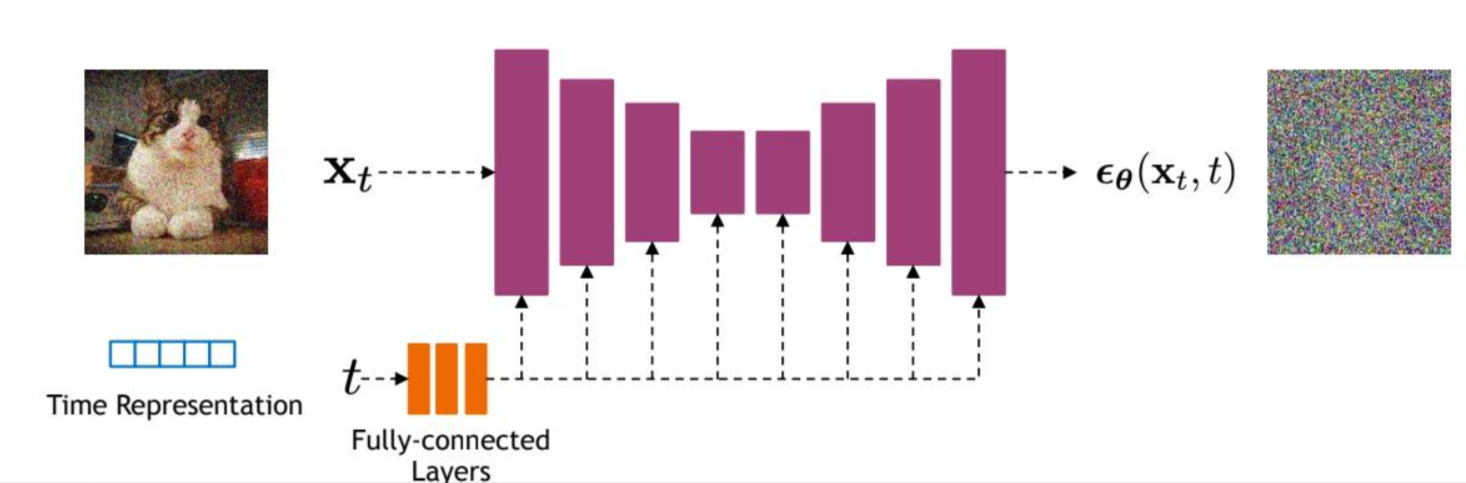

In [15]:
# 完整的UNet模型与attention和时间步嵌入
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        
        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2
        
        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )
        
        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        
        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

下面这段代码定义了两种不同的 β 调度函数：`linear_beta_schedule` 和 `cosine_beta_schedule`。这些函数用于生成一个 β 值序列，通常在变分自编码器（VAE）或扩散模型等生成模型中作为正则化项的权重或步骤间更新规则。β 值随着训练过程中的时间步（timesteps）线性或按余弦规律变化。接下来分别详细解释这两个函数：

**linear_beta_schedule(timesteps)**

- **输入**：`timesteps`，一个整数，表示训练过程中的总时间步数。

- **过程**：
  - **计算比例因子 `scale`**：将 1000 除以 `timesteps`，得到一个比例因子。这个比例因子确保 β 值的范围适应给定的时间步数。

  - **设定起始与结束 β 值**：
    - `beta_start`：乘以比例因子后等于 0.0001，即在训练开始时使用的 β 值较小，意味着初期正则化强度较弱，允许模型更自由地学习数据分布。
    - `beta_end`：乘以比例因子后等于 0.02，即在训练结束时使用的 β 值较大，意味着后期正则化强度增强，有助于模型更好地捕获数据的潜在结构并防止过拟合。

  - **生成线性 β 序列**：使用 `torch.linspace` 函数，根据 `beta_start` 和 `beta_end` 生成一个包含 `timesteps` 个元素的等间距浮点数序列，从 `beta_start` 线性递增至 `beta_end`。该序列的 dtype 设置为 `torch.float64`，确保高精度。

- **输出**：一个形状为 `(timesteps,)` 的 `torch.Tensor`，包含从训练开始到结束按线性规律变化的 β 值序列。

**cosine_beta_schedule(timesteps, s=0.008)**

- **输入**：
  - `timesteps`：同上，训练过程中的总时间步数。
  - `s`：默认值为 0.008，一个可选的调整参数，影响余弦曲线的形状。

- **过程**：
  - **扩展时间步数**：将 `timesteps` 加 1 得到 `steps`，以便在生成 `x` 时包括起始和结束点。

  - **生成均匀间隔的 `x`**：使用 `torch.linspace` 函数，生成一个从 0 到 `timesteps`（包含端点）的均匀间隔序列，长度为 `steps`，dtype 为 `torch.float64`。

  - **计算累积 α 值**：
    - 应用余弦函数公式，将 `x` 除以 `timesteps` 后加上 `s`，再除以 `1 + s`，乘以 π/2，然后取平方，得到 `alphas_cumprod`。此公式源自论文 [https://arxiv.org/abs/2102.09672] 中提出的余弦调度策略，用于生成一系列累积 α 值。
    - 归一化 `alphas_cumprod`，使其第一个元素为 1，确保后续计算的正确性。

  - **计算 β 值**：利用累积 α 值的相邻比值（`alphas_cumprod[1:] / alphas_cumprod[:-1]`）计算 β 值序列。`1 - (cumulative_ratio)` 的形式保证了 β 值从 1 逐渐减小到接近 0，符合 β 调度通常的要求。

  - **裁剪 β 值**：使用 `torch.clip` 函数将计算得到的 β 值限制在 [0, 0.999] 范围内，避免数值问题。

- **输出**：一个形状为 `(timesteps,)` 的 `torch.Tensor`，包含从训练开始到结束按余弦规律变化的 β 值序列，遵循论文中提出的调度策略。

综上，`linear_beta_schedule` 和 `cosine_beta_schedule` 分别实现了线性和余弦规律的 β 调度函数，用于生成随训练时间步数变化的 β 值序列，这些序列在生成模型训练过程中调控正则化强度或其他相关参数。线性调度简单地在训练初期赋予较小的 β 值，后期赋予较大的 β 值；而余弦调度遵循论文所提方案，生成更平滑且非单调的 β 变化曲线，可能有利于模型的训练收敛和性能优化。

In [17]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

下面这段代码定义了一个名为`GaussianDiffusion`的类，用于实现基于高斯扩散模型（Gaussian Diffusion Model）的图像生成任务。以下是代码各部分的详细解读：

**初始化方法 `__init__`**

- **参数**：
  - `timesteps`: 整数，指定扩散过程中的时间步数，即从纯噪声逐渐向原始数据扩散的步骤数量。
  - `beta_schedule`: 字符串，决定每个时间步的`beta`值如何随时间变化。这里支持两种类型：
    - `'linear'`: 使用线性β调度。
    - `'cosine'`: 使用余弦β调度。

- **内部变量**：
  - `betas`: 根据所选的`beta_schedule`计算得到的时间步对应的`beta`值序列。
  - `alphas`, `alphas_cumprod`, `alphas_cumprod_prev`: 与`beta`相关的中间变量，用于后续计算扩散过程中不同时间步的概率和协方差。
  - `sqrt_alphas_cumprod`等：计算扩散过程中的多项关键统计量（如均值、方差、对数方差等），这些量在后续的采样和损失计算中会用到。
    1. `self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)`:这行代码计算 `self.alphas_cumprod` 张量的平方根。`self.alphas_cumprod` 通常是一个包含累积乘积的张量，代表在扩散过程中每个时间步的累积扩散系数的平方根。
    2. `self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)`:这行代码计算 `1.0 - self.alphas_cumprod` 的平方根。这个量通常代表在扩散过程中每个时间步的剩余扩散系数的平方根。
    3. `self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)`:这行代码计算 `1.0 - self.alphas_cumprod` 的自然对数。这个量在计算扩散过程中的对数似然时非常有用。
    4. `self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)`:这行代码计算 `1.0 / self.alphas_cumprod` 的平方根。这个量代表累积扩散系数的倒数平方根，用于反向扩散过程。
    5. `self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)`:这行代码计算 `1.0 / self.alphas_cumprod - 1` 的平方根。这个量也用于反向扩散过程，代表累积扩散系数的倒数减一后的平方根。
    
    这些计算通常在训练扩散模型时使用，特别是在模型的正向和反向过程中，用于模拟数据如何被噪声干扰以及如何从噪声中恢复数据。这些量在扩散模型的算法中扮演着关键角色，例如在去噪扩散概率模型（DDPM）中。
  
  - `posterior_variance`, `posterior_log_variance_clipped`, `posterior_mean_coef1`, `posterior_mean_coef2`: 计算后验分布$q(x_{t-1} | x_t, x_0)$的均值、方差及系数，用于逆向扩散过程中的预测。

**辅助方法 `_extract`**

- **功能**：从预先计算好的统计量张量中提取对应于给定时间步`t`的值，并将其调整为与输入形状`x_shape`一致。

**扩散过程相关方法**

- **`q_sample`**: 根据前向扩散过程公式，给定初始状态`x_start`和时间步`t`，以及可选的随机噪声，生成对应的扩散状态`x_t`。此方法实现了扩散模型的前向过程。

- **`q_mean_variance`**: 返回当前时间步`t`下，给定初始状态`x_start`时扩散分布$q(x_t | x_0)$的均值和方差（以及对数方差）。

- **`q_posterior_mean_variance`**: 返回给定`x_start`、`x_t`和时间步`t`时，后验分布$q(x_{t-1} | x_t, x_0)$的均值、方差和对数方差（经过剪裁避免数值问题）。

- **`predict_start_from_noise`**: 给定当前状态`x_t`、时间步`t`以及预测噪声，计算原始状态`x_0`的估计值。这是逆向扩散过程的一部分。

**逆向扩散（解码）相关方法**

- **`p_mean_variance`**: 根据给定的神经网络模型、当前状态`x_t`和时间步`t`，计算逆向扩散过程中预测的$x_{t-1}$的均值、后验方差和对数方差。此方法涉及模型预测噪声、计算重构的`x_0`以及后验分布的统计量。

- **`p_sample`**: 在给定模型、当前状态`x_t`和时间步`t`的情况下，从后验分布中采样得到$x_{t-1}$。此方法用于单步逆向扩散过程。

- **`p_sample_loop`**: 通过迭代调用`p_sample`方法，执行完整的逆向扩散过程，从纯噪声逐步生成最终的图像。输出为整个扩散过程中的所有中间态。

- **`sample`**: 生成新的图像样本。调用`p_sample_loop`方法，指定图像尺寸、批次大小和通道数。

**训练相关方法**

- **`train_losses`**: 计算模型在给定真实数据`x_start`和时间步`t`上的训练损失。首先按照前向扩散过程生成带噪观测`x_noisy`，然后模型预测噪声，最后使用均方误差（MSE）计算预测噪声与真实噪声之间的差异作为损失。

总结来说，这个`GaussianDiffusion`类封装了基于高斯扩散模型的完整流程，包括前向扩散过程、逆向扩散过程（解码）、损失函数计算以及样本生成。通过设置不同的超参数（如时间步数、β调度方式等），可以调整模型的行为。同时，该类提供了与神经网络模型接口交互的方法，以便在训练和推理阶段进行协作。

结合`GaussianDiffusion`类的代码，下面是对训练过程每个步骤的解释：

1. **初始化模型和扩散过程参数**：
   - 实例化`GaussianDiffusion`类，指定所需的时间步数（`timesteps`）和β调度策略（`beta_schedule`）。这将计算出扩散过程中的关键参数，如`betas`、`alphas`等，这些参数用于定义数据如何随时间逐步被高斯噪声污染。

2. **准备训练数据**：
   - 准备好用于训练的图像数据集，通常包含大量标注或未标注的真实图像。这些图像会被转换为适合神经网络模型输入的格式，并按批次送入模型进行训练。

3. **定义神经网络模型**：
   - 创建一个神经网络模型，其主要任务是在给定当前扩散状态`x_t`和时间步`t`时，预测添加到原始数据上的噪声（即`predicted_noise`）。在您的代码中，这个模型并未直接定义，而是作为参数传递给`GaussianDiffusion`类的某些方法（如`train_losses`、`p_mean_variance`等）。这个模型通常是一个深度学习网络，例如U-Net或其他专门设计的架构，它能捕获数据的结构特征并预测噪声。

4. **前向扩散过程**：
   - 在训练期间，对于每个批次的真实图像`x_start`，代码通过`GaussianDiffusion.q_sample`方法模拟前向扩散过程。根据给定的时间步`t`和随机噪声，生成对应时间步的带噪观测`x_noisy`。这个过程遵循扩散模型的前向方程，将真实图像逐渐与高斯噪声混合。

5. **计算损失**：
   - 使用`GaussianDiffusion.train_losses`方法计算损失。该方法接收神经网络模型、真实图像`x_start`和当前时间步`t`作为输入。首先通过前向扩散得到带噪观测`x_noisy`，然后模型预测噪声`predicted_noise`。最后，计算模型预测噪声与实际添加到`x_start`上的噪声之间的均方误差（MSE），作为训练损失。

6. **反向传播与优化**：
   - 将上述计算得到的损失反向传播到神经网络模型中，更新模型参数。通常使用梯度下降或其变种（如Adam）优化算法来最小化损失函数。这个过程依赖于深度学习框架（如PyTorch）的自动微分机制。

7. **重复训练循环**：
   - 重复步骤2至6，遍历整个训练数据集多轮（epochs），逐步优化神经网络模型。在每一轮中，可能还会执行诸如学习率调整、模型保存、验证集评估等常规训练流程。

8. **评估与测试**：
   - 训练完成后，使用测试集或验证集评估模型性能。可以计算生成图像的质量指标（如FID分数、Inception Score等）来量化模型的生成能力。此外，还可以通过`GaussianDiffusion.sample`方法生成新图像，直观地评估模型的视觉表现。

综上所述，扩散模型的训练过程主要包括初始化扩散参数、准备数据、定义模型、执行前向扩散、计算损失、反向传播优化模型参数，并在多个训练周期中重复这些步骤。最终，通过评估指标和生成样本检验模型的训练效果。在您提供的代码中，`GaussianDiffusion`类为训练和生成提供了必要的支持函数，而具体的神经网络模型和训练循环则需要在外部实现和管理。

In [20]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
    
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance
        
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                    clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))
    
    # compute train losses
    def train_losses(self, model, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

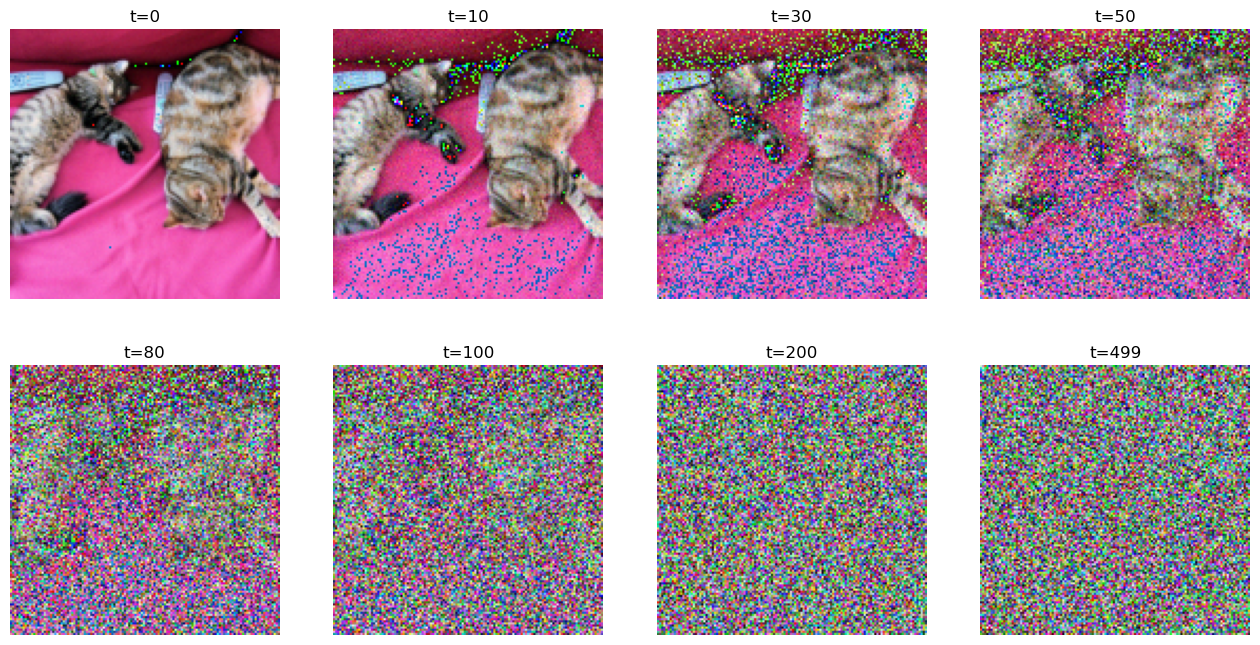

In [22]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
# image = Image.open("/data/000000039769.jpg")

image_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


x_start = transform(image).unsqueeze(0)

gaussian_diffusion = GaussianDiffusion(timesteps=500)

plt.figure(figsize=(16, 8))
for idx, t in enumerate([0,10, 30, 50, 80, 100, 200, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
    noisy_image = (x_noisy.squeeze().permute(1, 2, 0) + 1) * 127.5
    noisy_image = noisy_image.numpy().astype(np.uint8)
    plt.subplot(2, 4, 1 + idx)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t={t}")

In [23]:
batch_size = 64
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('/马金博/code/diffusion model/data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

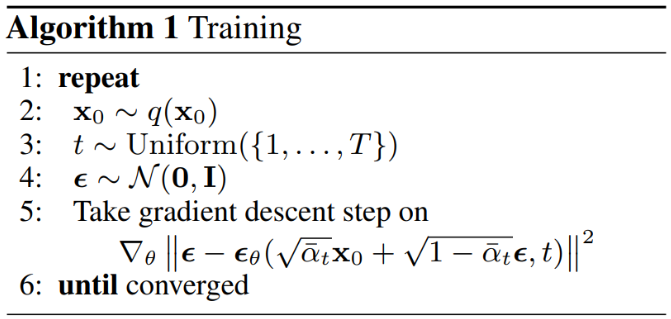
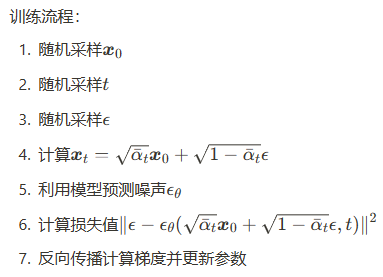

In [12]:
# train
epochs = 10

for epoch in range(epochs):
    for step, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 200 == 0:
            print("Loss:", loss.item())
            
        loss.backward()
        optimizer.step()

Loss: 1.2293858528137207
Loss: 0.048636436462402344
Loss: 0.036776937544345856
Loss: 0.021980689838528633
Loss: 0.03472277522087097
Loss: 0.03629327565431595
Loss: 0.027732810005545616
Loss: 0.02173670008778572
Loss: 0.03408452495932579
Loss: 0.02287278324365616
Loss: 0.022973554208874702
Loss: 0.029819021001458168
Loss: 0.02517351321876049
Loss: 0.02930438704788685
Loss: 0.029772043228149414
Loss: 0.02171069197356701
Loss: 0.02137831039726734
Loss: 0.02986033260822296
Loss: 0.024530036374926567
Loss: 0.03194285184144974
Loss: 0.02475213073194027
Loss: 0.024675240740180016
Loss: 0.024011483415961266
Loss: 0.027111198753118515
Loss: 0.02915370836853981
Loss: 0.027677267789840698
Loss: 0.025965295732021332
Loss: 0.023907558992505074
Loss: 0.026878492906689644
Loss: 0.02341807633638382
Loss: 0.030910613015294075
Loss: 0.03286779299378395
Loss: 0.02561138942837715
Loss: 0.018740864470601082
Loss: 0.014295531436800957
Loss: 0.02079291269183159
Loss: 0.025075113400816917
Loss: 0.020791316404

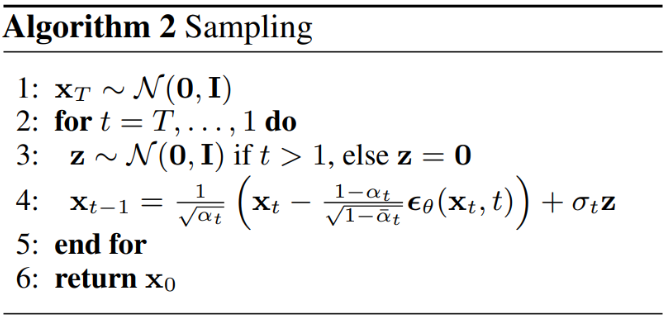
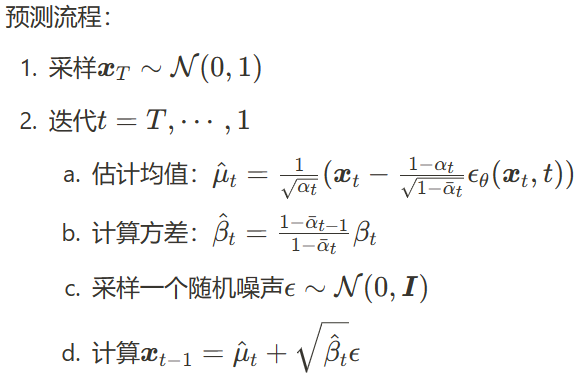

In [13]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

sampling loop time step: 100%|███████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.62it/s]


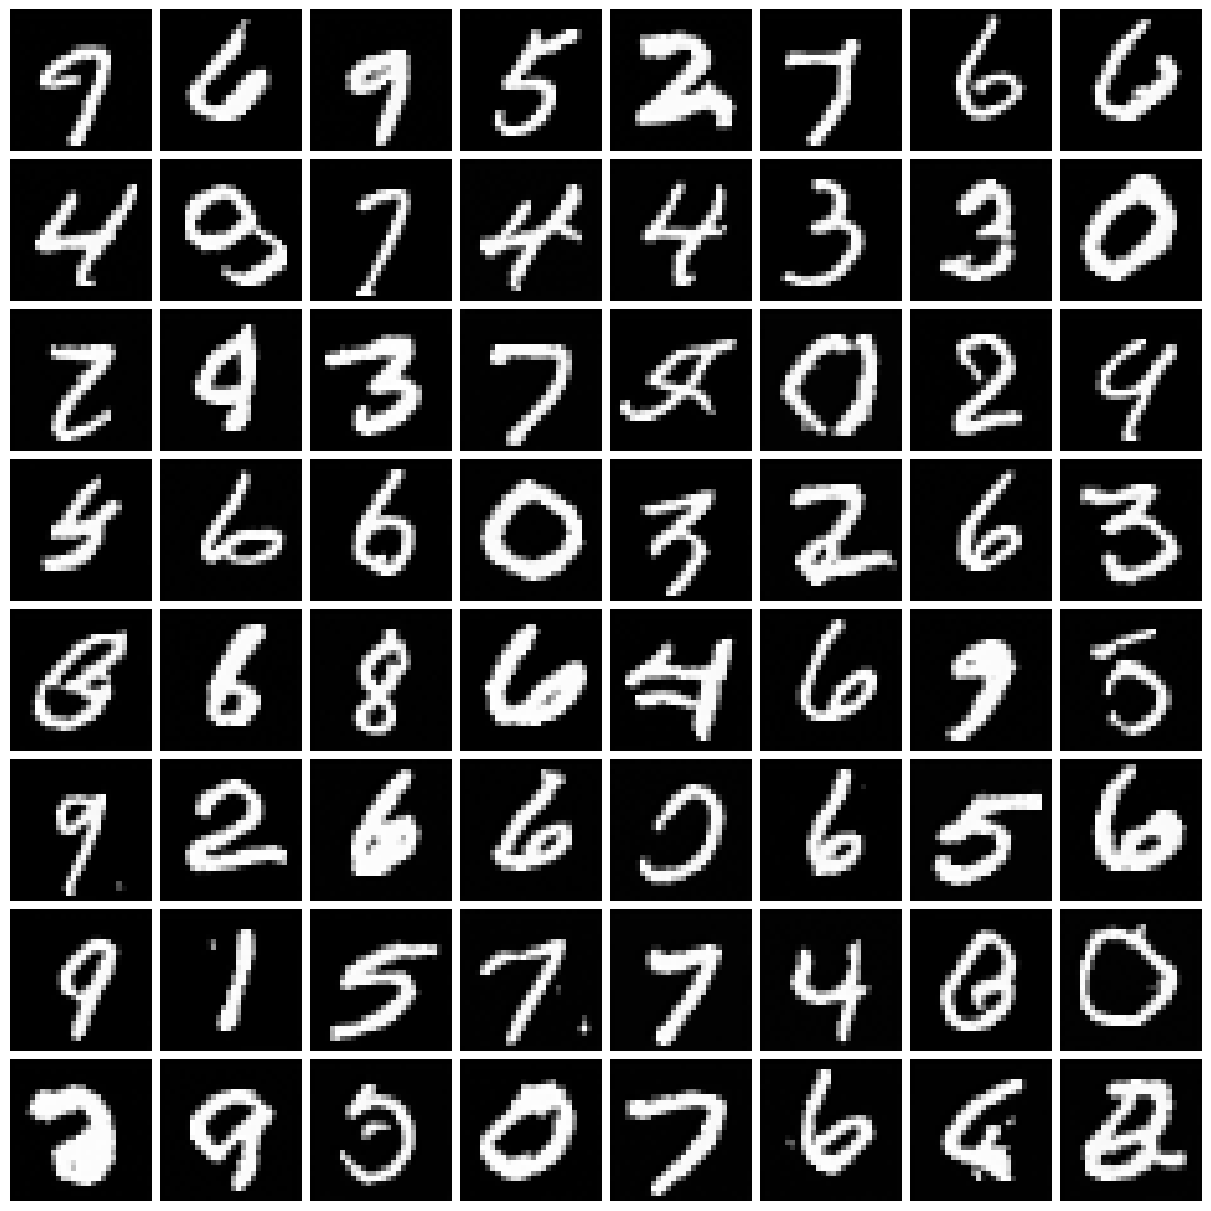

In [14]:
# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

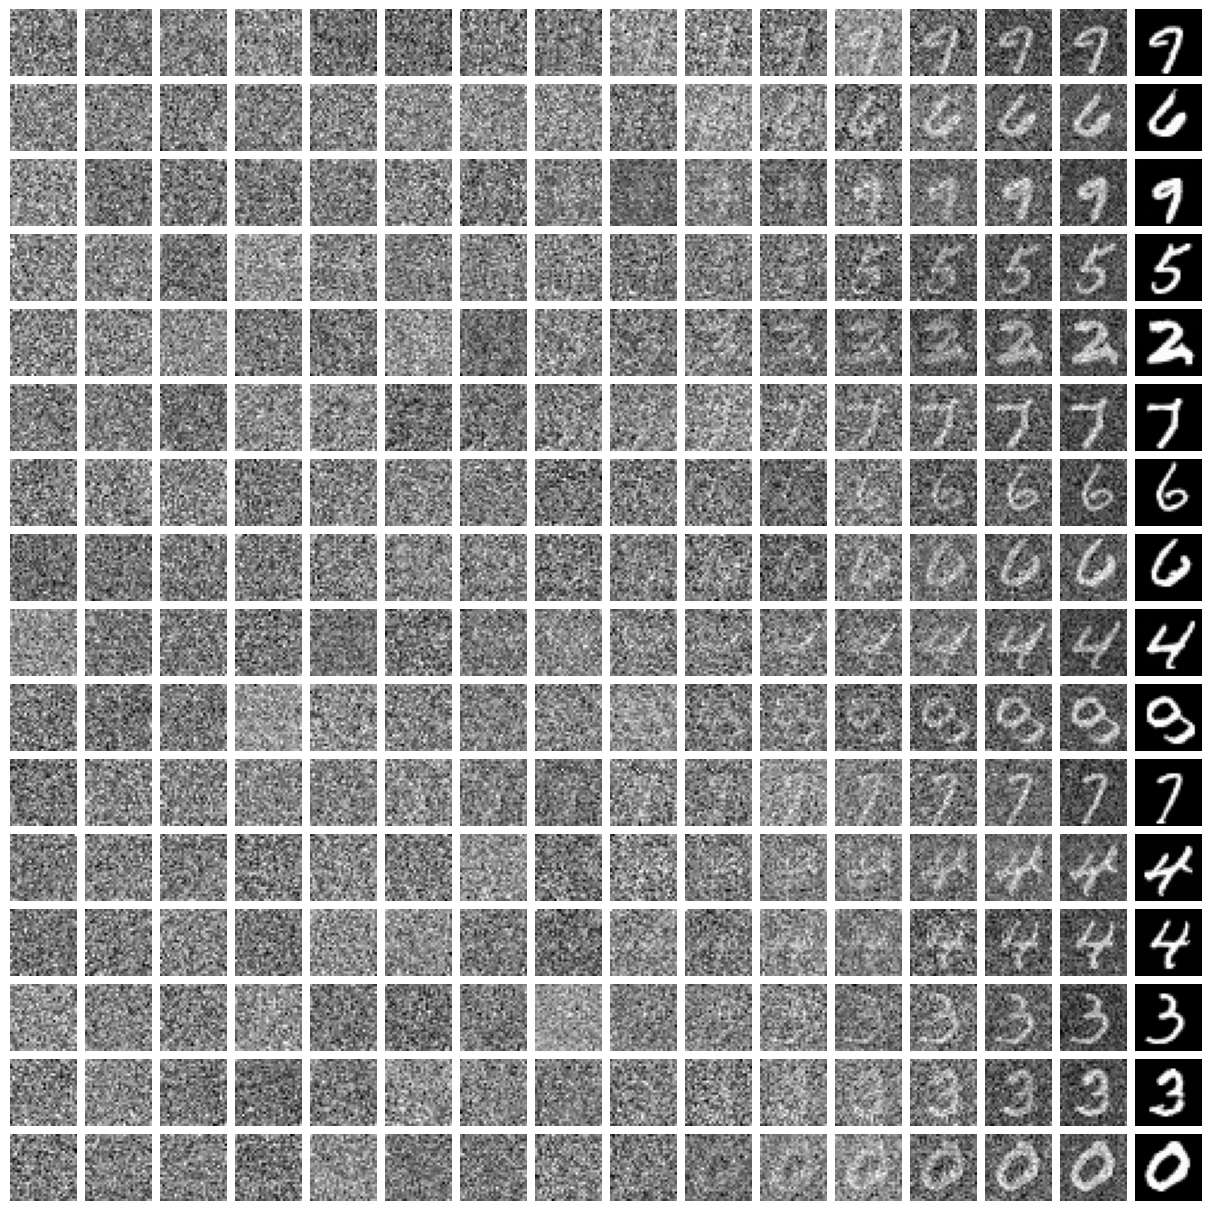

In [15]:
# show the denoise steps
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(16, 16)

for n_row in range(16):
    for n_col in range(16):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        t_idx = (timesteps // 16) * n_col if n_col < 15 else -1
        img = generated_images[t_idx][n_row].reshape(28, 28)
        f_ax.imshow((img+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")